In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id': '1tg7uu8GvstsNh8tMo5xq0kyCz9PHgB9s'})
downloaded.GetContentFile('train_identity.csv')

downloaded = drive.CreateFile({'id': '1fFEYaig3cowq6K_TkJAt4DpMW3zVxekR'})
downloaded.GetContentFile('train_transaction.csv')

In [ ]:
identity = pd.read_csv('train_identity.csv', encoding='latin-1')
transaction = pd.read_csv('train_transaction.csv', encoding='latin-1')
join = transaction.merge(identity, left_on= 'TransactionID', right_on='TransactionID',how='outer')

identity = None
transaction = None

In [ ]:
identity = pd.read_csv('train_identity.csv', encoding='latin-1')

In [ ]:
join.drop(['TransactionID'], axis = 1, inplace=True)

In [ ]:
join.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,315.0,87.0,19.0,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,NaN,13.0,NaN,NaN,NaN,NaN,NaN,NaN,13.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,NaN,outlook.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,NaN,NaN,yahoo.com,NaN,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,NaN,NaN,NaN,NaN,84.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NotFound,NaN,-480.0,New,NotFound,166.0,NaN,542.0,144.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New,NotFound,Android 7.0,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


Para mi set de validación me voy a quedar con los que sean después de los 140 dias (aprox el 20%), osea **TransactionDT >= 140*86400 = 12.096.000**

In [ ]:
train = join[join['TransactionDT'] < 12096000]
validation = join[join['TransactionDT'] >= 12096000]

join = None

**Tema: NaN**

Si son de features numericos: pasaran a ser el promedio de la columna.

Si son de features no numericos: pasaran a ser el valor 'Desconocido' (pasa a ser una categoría del feature)

In [ ]:
aux = train.select_dtypes(include = {'float64', 'int64'}).columns.values.tolist()
aux2 = {}
for elem in aux:
  aux2[elem] = train[elem].mean()

train.fillna(aux2, inplace=True)
validation.fillna(aux2, inplace=True)
# Hasta acá solo quedaron en NaN los de variables no numericas
train.fillna('Desconocido', inplace=True)
validation.fillna('Desconocido', inplace=True)

Algunos features tienen bastantes categorías, para achicarlo un poco me quedo con el top 10 y el resto serán categoría "Otros"

In [ ]:
device_info = train['DeviceInfo'].value_counts().to_frame().head(10).index
train.loc[~train['DeviceInfo'].isin(device_info), 'DeviceInfo'] = 'Otros'
validation.loc[~validation['DeviceInfo'].isin(device_info), 'DeviceInfo'] = 'Otros'

id_30 = train['id_30'].value_counts().to_frame().head(10).index
train.loc[~train['id_30'].isin(id_30), 'id_30'] = 'Otros'
validation.loc[~validation['id_30'].isin(id_30), 'id_30'] = 'Otros'

id_33 = train['id_33'].value_counts().to_frame().head(10).index
train.loc[~train['id_33'].isin(id_33), 'id_33'] = 'Otros'
validation.loc[~validation['id_33'].isin(id_33), 'id_33'] = 'Otros'

**One Hot Encoder:**

Voy a utilizar get_dummies

In [ ]:
ohe = pd.get_dummies(train['card4'], drop_first = False, dummy_na = True)
ohe.head()

,Desconocido,american express,discover,mastercard,visa,NaN
0,0,0,1,0,0,0
1,0,0,0,1,0,0
2,0,0,0,0,1,0
3,0,0,0,1,0,0
4,0,0,0,1,0,0


In [ ]:
train.drop(['card4'], axis = 1, inplace = True)

In [ ]:
train = pd.concat([train, ohe], axis = 1)

In [ ]:
ohe2 = pd.get_dummies(validation['card4'], drop_first = False, dummy_na = True)
validation.drop(['card4'], axis = 1, inplace = True)
validation = pd.concat([validation, ohe2], axis = 1)

**Count Vectorizer**

In [ ]:
cv = CountVectorizer()
voc_train = cv.fit_transform(train['id_31'].tolist())
voc_validation = cv.transform(validation['id_31'].tolist())
vocabulary = cv.vocabulary_

TOP 20 de palabras más comunes para id_31:

In [ ]:
vocabulary = cv.vocabulary_
vocabulary = sorted(vocabulary.items(), key=lambda x: x[1], reverse=True)
aux = list(vocabulary)[0:20]
aux2 = list(vocabulary)[20:]

voc_20 = [i[0] for i in aux]
voc_a_borrar = [i[0] for i in aux2]

vocabulary = None
aux = None
aux2 = None

voc_20

['zte',
 'windows',
 'webview',
 'waterfox',
 'uiwebview',
 'tablet',
 'sm',
 'silk',
 'seamonkey',
 'sch',
 'samsung',
 'safari',
 'puffin',
 'palemoon',
 'other',
 'opera',
 'nokia',
 'mozilla',
 'mobile',
 'minion']

In [ ]:
vc_train = pd.DataFrame(voc_train.todense(), columns=cv.get_feature_names_out())
vc_train.drop(voc_a_borrar, axis=1, inplace=True)
voc_train = None
vc_train.head()

,minion,mobile,mozilla,nokia,opera,other,palemoon,puffin,safari,samsung,sch,seamonkey,silk,sm,tablet,uiwebview,waterfox,webview,windows,zte
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
vc_validation = pd.DataFrame(voc_validation.todense(), columns=cv.get_feature_names_out())
vc_validation.drop(voc_a_borrar, axis=1, inplace=True)
voc_validation = None

In [ ]:
vc_validation.head()

,minion,mobile,mozilla,nokia,opera,other,palemoon,puffin,safari,samsung,sch,seamonkey,silk,sm,tablet,uiwebview,waterfox,webview,windows,zte
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Ahora teniendo esto, las agrego a los dataframes correspondientes:

In [ ]:
train.drop(['id_31'], axis = 1, inplace = True)
train = pd.concat([train, vc_train], axis = 1)

In [ ]:
train.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,...,id_26,id_27,id_28,id_29,id_30,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo,Desconocido,american express,discover,mastercard,visa,NaN,minion,mobile,mozilla,nokia,opera,other,palemoon,puffin,safari,samsung,sch,seamonkey,silk,sm,tablet,uiwebview,waterfox,webview,windows,zte
0,0,86400,68.5,W,13926,362.857208,150.0,142.0,credit,315.0,87.0,19.000000,237.634827,Desconocido,Desconocido,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,167.222367,13.000000,134.84658,42.362001,63.829504,44.639849,149.826877,0.560621,13.000000,13.000000,...,148.303672,Desconocido,Desconocido,Desconocido,Desconocido,26.599803,Desconocido,Desconocido,Desconocido,Desconocido,Desconocido,Desconocido,Desconocido,Desconocido,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,86401,29.0,W,2755,404.000000,150.0,102.0,credit,325.0,87.0,121.633845,237.634827,gmail.com,Desconocido,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,167.222367,28.636094,0.00000,42.362001,63.829504,44.639849,149.826877,0.560621,0.000000,138.022709,...,148.303672,Desconocido,Desconocido,Desconocido,Desconocido,26.599803,Desconocido,Desconocido,Desconocido,Desconocido,Desconocido,Desconocido,Desconocido,Desconocido,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,86469,59.0,W,4663,490.000000,150.0,166.0,debit,330.0,87.0,287.000000,237.634827,outlook.com,Desconocido,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,167.222367,28.636094,0.00000,42.362001,63.829504,44.639849,149.826877,0.560621,0.000000,315.000000,...,148.303672,Desconocido,Desconocido,Desconocido,Desconocido,26.599803,Desconocido,Desconocido,Desconocido,Desconocido,Desconocido,Desconocido,Desconocido,Desconocido,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,86499,50.0,W,18132,567.000000,150.0,117.0,debit,476.0,87.0,121.633845,237.634827,yahoo.com,Desconocido,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.000000,0.000000,94.00000,0.000000,63.829504,44.639849,149.826877,0.560621,84.000000,138.022709,...,148.303672,Desconocido,Desconocido,Desconocido,Desconocido,26.599803,Desconocido,Desconocido,Desconocido,Desconocido,Desconocido,Desconocido,Desconocido,Desconocido,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,86506,50.0,H,4497,514.000000,150.0,102.0,credit,420.0,87.0,121.633845,237.634827,gmail.com,Desconocido,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,167.222367,28.636094,134.84658,42.362001,63.829504,44.639849,149.826877,0.560621,118.256468,138.022709,...,148.303672,Desconocido,New,NotFound,Android 7.0,32.000000,Otros,match_status:2,T,F,T,T,mobile,Otros,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
validation.drop(['id_31'], axis = 1, inplace = True)
vc_validation.index = validation.index
validation = pd.concat([validation, vc_validation], axis = 1)

**Mean encoding**

Para el resto de features que son texto les voy a aplicar el mean encoding

In [ ]:
a_encodear = train.select_dtypes(include = object).columns.values.tolist()
mean_encoded = {}
for elem in a_encodear:
  mean_encoded.update(train.groupby([elem])['isFraud'].mean().to_dict())
  train[elem] =  train[elem].map(mean_encoded)

a_encodear = None

In [ ]:
prom_features_train = {}
for column in train:
  prom_features_train[column] = train[column].mean()

In [ ]:
for column in validation:
  if (validation[column].dtype == object):
    validation[column] = validation[column].replace(mean_encoded)

Deben utilizar al menos 80 features (contando cómo features columnas con
números, pueden venir varios de la misma variable).

Deben utilizar las columnas: id_31, id_33, DeviceType, DeviceInfo.

Los ultimos 20 features del train/validation son de id_31

Voy a trabajar con 100 features en total.



In [ ]:
x_train = train.drop('isFraud', axis=1)
y_train = train['isFraud']

x_valid = validation.drop('isFraud', axis=1)
y_valid = validation['isFraud']

train = None
validation = None

In [ ]:
feat_obligatorios = list(x_train.iloc[:, 436:].columns)
feat_obligatorios.append('DeviceType')
feat_obligatorios.append('DeviceInfo')
feat_obligatorios.append('id_33')
feat_obligatorios

['minion',
 'mobile',
 'mozilla',
 'nokia',
 'opera',
 'other',
 'palemoon',
 'puffin',
 'safari',
 'samsung',
 'sch',
 'seamonkey',
 'silk',
 'sm',
 'tablet',
 'uiwebview',
 'waterfox',
 'webview',
 'windows',
 'zte',
 'DeviceType',
 'DeviceInfo',
 'id_33']

In [ ]:
len(feat_obligatorios)

23

**PUNTO EXTRA**: Agregar una técnica de feature selection para algún modelo de la parte III (1 punto)

Voy a utilizar la tecnica: **Univariate Selection**

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

aux = x_train.copy()
aux.drop(feat_obligatorios, axis=1, inplace=True)
for colum in aux:
  aux[colum] = aux[colum].abs()  #necesito todo positivo

bestfeatures = SelectKBest(score_func=chi2, k=10)

fit = bestfeatures.fit(aux,y_train)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(aux.columns)
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Feature','Score']

x_train2 = None

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [ ]:
featureScores = featureScores.sort_values('Score', ascending=False)
featureScores.head()

,Feature,Score
0,TransactionDT,5.120422e+08
392,id_02,2.428382e+07
211,V160,2.355410e+07
368,V317,1.477226e+07
358,V307,9.021549e+06


Quiero trabajar con 100 features en total, ya tengo 23 (de los obligatorios) así que me quedare con los 77 de mayor score

In [ ]:
features = feat_obligatorios + list(featureScores.iloc[:77,:]['Feature'])

In [ ]:
x_train = x_train.loc[:, features]

x_valid = x_valid.loc[:, features]

# **Random Forest**

In [ ]:
rfc = RandomForestClassifier(random_state = 40, n_estimators=15)

params = {"max_depth": [3, 2, 5, None],
          "max_features": [1, 3, 20],
          "min_samples_split": [1, 3, 10],
          "min_samples_leaf": [1, 3, 10]
          }

model = RandomizedSearchCV(rfc, params, random_state=40, n_jobs = 1, n_iter = 20, cv = 5, scoring="roc_auc")

Para evitar warnings de FutureWarning:

In [ ]:
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

In [ ]:
model.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
55 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
55 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 459, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/par

RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_estimators=15,
                                                    random_state=40),
                   n_iter=20, n_jobs=1,
                   param_distributions={'max_depth': [3, 2, 5, None],
                                        'max_features': [1, 3, 20],
                                        'min_samples_leaf': [1, 3, 10],
                                        'min_samples_split': [1, 3, 10]},
                   random_state=40, scoring='roc_auc')

Los mejores hiperparametros que se encontraron:

In [ ]:
best_params = model.best_estimator_.get_params()
best_params

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': 3,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 15,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 40,
 'verbose': 0,
 'warm_start': False}

In [ ]:
roc_auc_score(y_train, model.predict_proba(x_train)[:,1])

0.8116233242984872

El random search ya me devuelve el modelo con el mayor score posible, entonces con el set de validación:

In [ ]:
roc_auc_score(y_valid, model.predict_proba(x_valid)[:,1])

0.8126601657314841

Comparado con el otro modelo, este da un menor roc_auc.

**PUNTO EXTRA**  Graficar la matriz de confusión para algún modelo de la parte III

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_valid, model.predict(x_valid))

array([[116987,      0],
       [  4147,     29]])

A partir de esta matriz se puede ver como el sistema falla mucho al predecir correctamente los que verdaderamente son fraude. En lo casos que NO son fraudes predice perfectamente.

**PUNTO EXTRA**  Graficar la importancia de features para algún modelo de la parte III. ¿Qué tanto se
parece a los features importantes de la parte II? 

In [ ]:
#Por el Randomized Search, no puedo usar el feature_importances de Random Forest
rf = RandomForestClassifier(**best_params)
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=3, max_features=3, min_samples_split=10,
                       n_estimators=15, random_state=40)

In [ ]:
importances = rf.feature_importances_

In [ ]:
columns_names = x_train.columns.values.tolist()
dic = {}
for i in range(len(importances)):
  dic[columns_names[i]] = importances[i]

df = pd.DataFrame([[key, dic[key]] for key in dic.keys()], columns=['Feature', 'Importancia'])
df = df.sort_values('Importancia',ascending=False)
df.set_index('Feature',inplace = True)

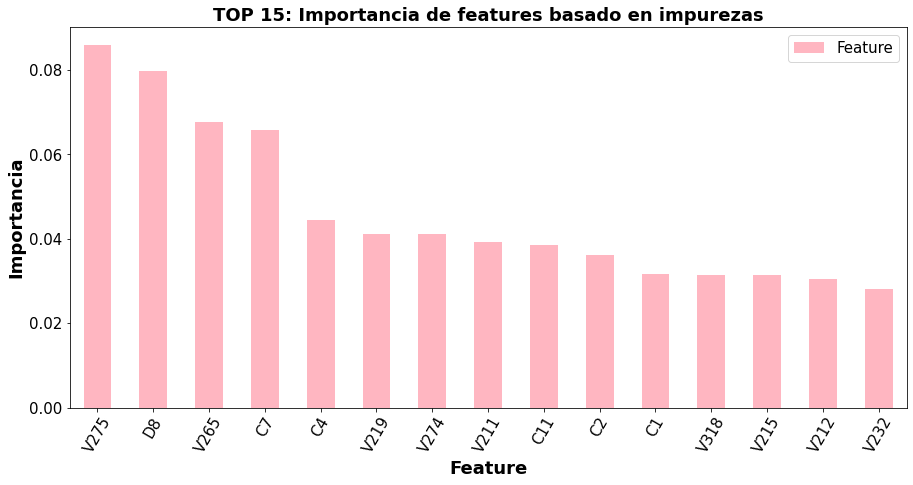

In [ ]:
import matplotlib.pyplot as plt
df.iloc[0:15].plot.bar(logy=True, figsize=(15, 7), rot=60, color='lightpink', fontsize=15)
plt.title('TOP 15: Importancia de features basado en impurezas', fontsize = 18, fontweight='bold')
plt.xlabel('Feature', fontsize=18, fontweight='bold')
plt.ylabel('Importancia', fontsize=18, fontweight='bold')
plt.yscale(value='linear')
plt.legend(('Feature',), loc='upper right', prop={'size':15})

plt.show()

No coincide ningún feature de acá con los de la parte 2. En parte se puede deber a que acá estamos usando menos features y también por la forma de calcular la importancia